In [34]:
import os
import json
import uuid
import pandas as pd
import torch
import torchaudio
#from torchvision.models import resnet18
from b2aiprep.process import Audio, specgram, plot_spectrogram
import IPython.display as Ipd
#from torchsummary import summary

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [36]:
def determine_is_stridor(path):
    """
    Determine if the path should be marked as stridor based on the parent folder.
    """
    for part in path.split(os.sep):
        if part.upper() in ["CONTROL", "CONTROLS"]:
            return False
    return True

def generate_recording_objects(root_path, output_json):
    recordings = []

    # Traverse the directory structure
    for root, dirs, files in os.walk(root_path):
        # Check if there are wav files in the current directory
        wav_files = [file for file in files if file.endswith('.wav')]
        if wav_files:
            # Get the parent folder name
            parent_folder = os.path.basename(root)
            # Determine the isStridor value
            is_stridor = determine_is_stridor(root)
            
            for wav_file in wav_files:
                # Generate a unique ID for each player-session-recording combination
                uid = str(uuid.uuid4())
                # Extract the recording label (base name without extension)
                recording_label = os.path.splitext(wav_file)[0]
                # Create the entry for the current recording
                entry = {
                    "uid": uid,
                    "name": parent_folder,
                    "recording": os.path.join(root, wav_file),  # Include the full path
                    "recording_label": recording_label,
                    "isStridor": is_stridor
                }
                recordings.append(entry)
                
    return recordings

In [37]:
def filter_recordings_by_label(data, label_prefix):
    """
    Filter recordings to only include those with recording_label starting with the specified prefix.
    Exclude specific labels when the prefix is 'FIMO'.
    """
    exclude_labels = {"FIMO": ["FIMOcricoid", "FIMOthyroid", "FIMOC", "FIMOT"]}

    filtered_data = []
    for recording in data:
        if recording['recording_label'].startswith(label_prefix):
            if label_prefix == "FIMO" and recording['recording_label'] in exclude_labels["FIMO"]:
                continue
            filtered_data.append(recording)

    return filtered_data

In [38]:
# Usage
root_path = '/data/parsak/stridor/Data files'  # Replace with the actual path to your folders
output_json = 'output_individual.json'  # Replace with the desired output JSON file name
data = generate_recording_objects(root_path, output_json)

#print(f"rcordings: {data}")

In [39]:
# Filter the data to only include recordings with recording_label starting with "FIMO"
filtered_data = filter_recordings_by_label(data, "FIMO")

#print(f"filtered recordings: {filtered_data}")

In [40]:
df = pd.DataFrame(data)

print(f"df: {df}")

df:                                       uid        name  \
0    8c5cff53-5bbf-477f-b759-2bc0b8150d74   Patient 1   
1    bd29c8b4-cf91-4b23-9372-6b69443a984c   Patient 1   
2    1dafbdad-177e-434d-95c5-f822186e52c5   Patient 1   
3    3455c163-a63b-4049-80ab-a21f75c02bfa   Patient 1   
4    053dbf1c-142e-47a8-8ec4-67288d2c83ba   Patient 1   
..                                    ...         ...   
722  cbd81f95-d611-4ff2-9470-f7bff5d10ccf  Patient 20   
723  19e80495-9671-434c-9a11-0dac6dc7edca  Patient 20   
724  a53e2a25-8832-408d-a75a-72b395059c99  Patient 20   
725  934d5bd5-6fd1-4e2f-9f02-94b41399eb99  Patient 20   
726  90c0e242-d351-4875-bdc6-9760cc35e7e0  Patient 20   

                                             recording  \
0    /data/parsak/stridor/Data files/OLD methods/IN...   
1    /data/parsak/stridor/Data files/OLD methods/IN...   
2    /data/parsak/stridor/Data files/OLD methods/IN...   
3    /data/parsak/stridor/Data files/OLD methods/IN...   
4    /data/parsak/str

In [41]:
class MySpecgramDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, segment_size=3):
        self.dataframe = dataframe
        self.segment_size = segment_size
        
        # Ensure the DataFrame has the necessary columns
        required_columns = ['uid', 'recording', 'recording_label', 'isStridor']
        for col in required_columns:
            if col not in dataframe.columns:
                raise ValueError(f"DataFrame is missing required column: {col}")

        # Extract necessary information from the DataFrame
        self.audio_files = dataframe['recording'].tolist()
        self.labels = dataframe['isStridor'].tolist()
        self.uids = dataframe['uid'].tolist()
        self.recording_labels = dataframe['recording_label'].tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        uid = self.uids[idx]
        audio_file = self.audio_files[idx]
        label = self.labels[idx]
        recording_label = self.recording_labels[idx]

        try:
            audio = Audio.from_file(self.audio_files[idx])
            audio = audio.to_16khz()
            # get middle K seconds if audio is too long, pad with zeros if it is too short
            if audio.signal.size(0) > self.segment_size*16000:
                d = (audio.signal.size(0)-self.segment_size*16000)//2
                audio.signal = audio.signal[d:d+self.segment_size*16000]
            else:
                audio.signal = torch.nn.functional.pad(audio.signal, (0,self.segment_size*16000-audio.signal.size(0)), mode='constant', value=0)
                
            win_length = 30
            hop_length = 10
            nfft = 512
            features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
            features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10))).T
            
            features_specgram = torch.nn.functional.interpolate(features_specgram.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)

        except Exception as e:
            print(f"Error loading {audio_file}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        # Convert the label to a tensor
        label = torch.tensor(label, dtype=torch.float32)

        return {'uid': uid, 'signal': features_specgram, 'isStridor': label, 'recording_label': recording_label}

dataset: <__main__.MySpecgramDataset object at 0x15018d094450>
['FIMOavid', 'FEMC12inch', 'DeepAvid', 'RegAvid', '_FIMOcricoid', 'FIMOAvid', 'DeepiPad', 'FIMCcricoid'] tensor([1., 1., 1., 0., 1., 0., 1., 0.])


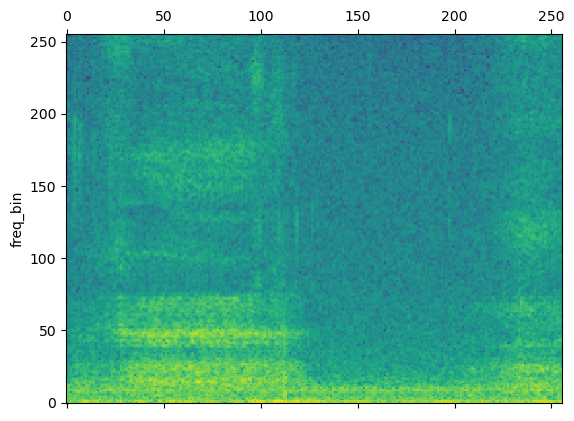

In [42]:
dataset = MySpecgramDataset(df)
print(f"dataset: {dataset}")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for batching and shuffling
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# Example: Iterate through the train DataLoader
for batch in train_dataloader:
    print(batch['recording_label'], batch['isStridor'])
    plot_spectrogram(batch['signal'][0])
    break

# Transformer

In [43]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 1, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [61]:
model = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)


In [47]:
def eval(model, dataloader):
    model.eval()
    acc = 0
    for batch in dataloader:
        signal = batch['signal'].to(device)  # Move batch to GPU
        with torch.no_grad():
            outputs = model(signal.view(-1, 1, signal.size(1), signal.size(2)))
        for i in range(len(batch['signal'])):
            if batch['isStridor'][i] == 1 and outputs[i][1].item() > 0.5:
                acc += 1
            if batch['isStridor'][i] == 0 and outputs[i][0].item() > 0.5:
                acc += 1

    return acc / len(dataloader.dataset)

# Assuming train_dataloader and val_dataloader are defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available

num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
    model.train()
    closs = []
    for batch in train_dataloader:
        optimizer.zero_grad()

        signal = batch['signal'].to(device)  # Move batch to GPU
        outputs = model(signal.view(-1, 1, signal.size(1), signal.size(2)))
        loss = torch.nn.functional.cross_entropy(outputs, batch['isStridor'].long().to(device))
        closs += [loss.item()] * len(batch['signal'])
        loss.backward()
        optimizer.step()

    train_acc = eval(model, train_dataloader)
    val_acc = eval(model, val_dataloader)
    print('Epoch:{:} TrainLoss:{:.4f} TrainACC:{:.4f} ValACC:{:.4f}'.format(epoch+1, sum(closs)/len(closs), train_acc, val_acc))

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './model.pth')
        print('Saved!')

Epoch:1 TrainLoss:0.8397 TrainACC:0.6231 ValACC:0.6667
Saved!
Epoch:2 TrainLoss:0.5918 TrainACC:0.7969 ValACC:0.7361
Saved!
Epoch:3 TrainLoss:0.4903 TrainACC:0.9053 ValACC:0.7222
Epoch:4 TrainLoss:0.2444 TrainACC:0.9639 ValACC:0.7639
Saved!
Epoch:5 TrainLoss:0.1653 TrainACC:0.9501 ValACC:0.7917
Saved!
Epoch:6 TrainLoss:0.1333 TrainACC:0.9673 ValACC:0.7639
Epoch:7 TrainLoss:0.1694 TrainACC:0.9948 ValACC:0.7500
Epoch:8 TrainLoss:0.0455 TrainACC:0.9897 ValACC:0.7639
Epoch:9 TrainLoss:0.0590 TrainACC:0.9897 ValACC:0.7639
Epoch:10 TrainLoss:0.0275 TrainACC:0.9948 ValACC:0.7500
Epoch:11 TrainLoss:0.0561 TrainACC:0.9914 ValACC:0.7222
Epoch:12 TrainLoss:0.0266 TrainACC:1.0000 ValACC:0.7778
Epoch:13 TrainLoss:0.0922 TrainACC:0.7642 ValACC:0.5556
Epoch:14 TrainLoss:0.2615 TrainACC:0.9948 ValACC:0.7639
Epoch:15 TrainLoss:0.0212 TrainACC:1.0000 ValACC:0.7917
Saved!
Epoch:16 TrainLoss:0.0057 TrainACC:1.0000 ValACC:0.7778
Epoch:17 TrainLoss:0.0009 TrainACC:1.0000 ValACC:0.8056
Saved!
Epoch:18 TrainL

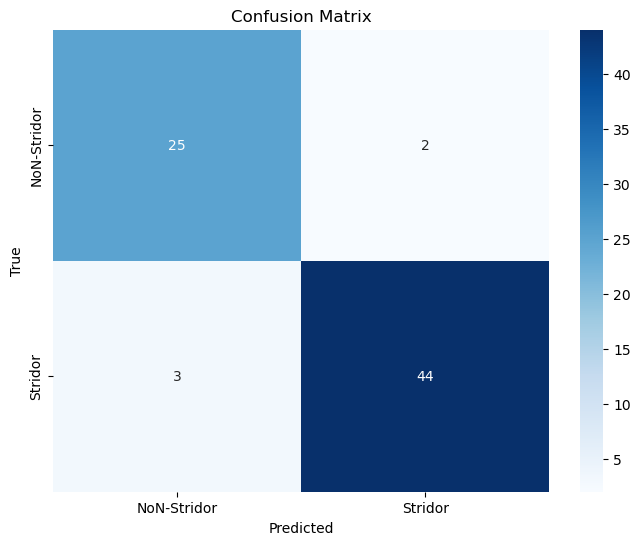

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.89      0.93      0.91        27
     Class 1       0.96      0.94      0.95        47

    accuracy                           0.93        74
   macro avg       0.92      0.93      0.93        74
weighted avg       0.93      0.93      0.93        74



In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_predictions_and_labels(model, dataloader, device):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            signal = batch['signal'].to(device)
            outputs = model(signal.view(-1, 1, signal.size(1), signal.size(2)).to(device))
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = batch['isStridor'].to(device).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    return all_preds, all_labels

# Assuming test_dataloader is defined and model is trained
model.load_state_dict(torch.load('./Stridor_ViT.pth'))

# Get predictions and true labels for the test set
preds, labels = get_predictions_and_labels(model, test_dataloader, device)

# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(labels, preds)
class_report = classification_report(labels, preds, target_names=['Class 0', 'Class 1'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NoN-Stridor', 'Stridor'], yticklabels=['NoN-Stridor' , 'Stridor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print('Classification Report:\n', class_report)

# Plot the confusion matrix

